In [1]:
clear all

In [2]:
import nibabel as nib
import os
import numpy as np
import scipy.io as sio
import scipy.optimize
from Tkinter import Tk
from tkFileDialog import askdirectory
import libtiff 
import matplotlib.pyplot as plt
%matplotlib inline

# Get folder

In [3]:
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
foldername = askdirectory() # show an "Open" dialog box and return the path to the selected file
print(foldername)

/media/sophie/TestTrigger/Data100298


In [4]:
path=foldername

In [5]:
A=foldername.split('/')
Dataname=A[-1]

In [6]:
Dataname

'Data100298'

In [7]:
from PIL import Image


# Open the images

In [8]:
im = Image.open(path+'/'+Dataname+'_1.tif')
tt = np.array(im)

S=tt.shape
data=np.zeros([S[0],S[1],len(os.listdir(path))])
#for i in range(1,15000):
for i in range(len(os.listdir(path))):       
#for fn in os.listdir(path):
    im = Image.open(path+'/'+Dataname+'_'+str(i+1)+'.tif')
    tt = np.array(im)
    data[:,:,i]=tt[:][:]
    i=i+1

In [9]:
S=data.shape
S

(4, 2048, 7506)

# Find end of onset of light and begining of offset (to align to behavior) 

Calculate average time series

In [10]:
M=np.mean(np.mean(data,0),0)
Mav=M.mean()
M=M/Mav

In [11]:
Mav

1613.2637699085524

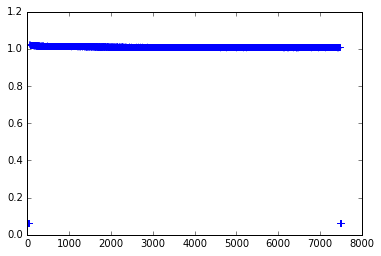

In [12]:
plt.plot(M,'+')
#plt.axis([-1,200,0,1.5])

Get approxiamte on and off times

In [13]:
liston=[i for i in range(len(M)) if M[i]>0.5]
liston[0]

52

Model for fitting onset and offset

In [14]:
def model(x,a,b,c,d):
    if x<a:
        return b
    elif x<c:
        return b+(x-a)*d
    else:
        return (c-a)*d+b

Model onset and find precise onset time

In [15]:
Ms=M[range(liston[0]-8,liston[0]+8)]

In [16]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))])   

In [17]:
liston[0]-8

44

In [18]:
res = scipy.optimize.minimize(Sq,x0=[7.6,0.3,9.1,0.9])

In [19]:
ON=liston[0]-8+res.x[2]
print(ON)

51.996600864


In [20]:
ONint=np.int(np.ceil(ON))
#ONint=1
print(ONint)

52


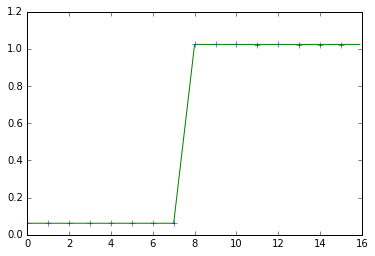

In [21]:
plt.plot(np.squeeze(M[range(liston[0]-8,liston[0]+8)]),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

Model offset and find precise offset time

In [22]:
Ms=M[range(liston[len(liston)-1]-6,liston[len(liston)-1]+6)]

In [23]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))]) 

In [24]:
res = scipy.optimize.minimize(Sq,x0=[6,3,8,-1])

In [25]:
OFF=liston[len(liston)-1]-6+res.x[0]
#OFF=liston[len(liston)-1]
print(OFF)
OFFint=np.int(np.floor(OFF))
print(OFFint)

7472.00059572
7472


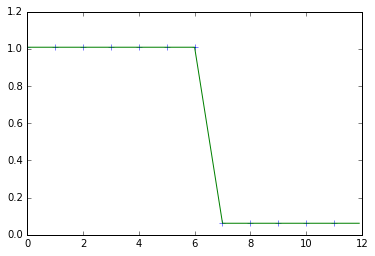

In [26]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

# Open images times

In [32]:
TimeFile='/home/sophie/Downloads/'+''.join([Dataname[i] for i in range(10)])+'_.csv'

In [33]:
print(TimeFile)

/home/sophie/Downloads/Data100298_.csv


In [34]:
Listfile = open(TimeFile, 'r')
ListTime = [line.split('\n')[0] for line in Listfile.readlines()]

In [35]:
Timespl=[float(ListTime[i].split(',')[2]) for i in range(1,len(ListTime))]

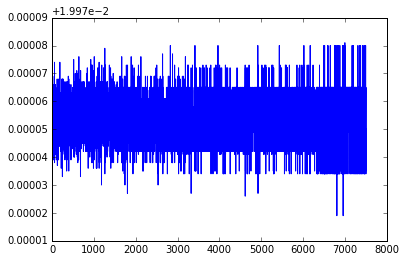

In [36]:
Ttest=np.array(Timespl[2:(len(Timespl))])-np.array(Timespl[1:(len(Timespl)-1)])
plt.plot(Ttest)
#plt.axis([10000,11000,0,0.6])

# Get times corresponding to images during light on (excitation light completely on : t=0)

In [50]:
print(ONint)
print(OFFint)
print(ON)
print(OFFint-ONint)
print(OFF-ON)

52
7472
51.996600864
7420
7420.00399486


In [38]:
TimeOn=[Timespl[i] for i in range(ONint,(OFFint+1))]

In [39]:
Tinit=(ON-(ONint-1))*(Timespl[ONint]-Timespl[ONint-1])+Timespl[ONint-1]

In [48]:
Toff=(OFF-OFFint)*(Timespl[OFFint+1]-Timespl[OFFint])+Timespl[OFFint]

In [49]:
Toff-Tinit

148.57789400080947

In [42]:
Timespl[ONint]-Timespl[ONint-1]

0.020027000000000017

In [43]:
TimeOn[0]-Tinit

6.8074495863656992e-05

In [44]:
import numpy as np

In [45]:
TimeOnFinal=np.array(TimeOn)-Tinit

In [46]:
sio.savemat('/home/sophie/Desktop/'+Dataname+'TimeFluoOn.mat', {'TimeFluoOn':TimeOnFinal})

# Keep only the frames for which the excitation is on and save

In [48]:
D4=np.transpose(data[:,:,:,range(ONint,(OFFint+1))],(2,1,0,3))
nim=nib.Nifti1Image(D4,np.eye(4))
nib.save(nim,'/home/sophie/Desktop/'+Dataname+'on.nii.gz')